## Vehicle Routing Problem

### Import Packages

In [1]:
from pyomo.environ import *
import pyomo.environ as pyo
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

random.seed(2)


### Inputs

In [2]:
#Generate Data Inputs

# Number of cities
n=20

# Number of Vehicles
nvhc=3

# Vehicle capacity
cvhc=230

#Coordinate Range
rangelct=10000

coordlct_x = random.sample(range(0, rangelct), n)

coordlct_y = random.sample(range(0, rangelct), n)

distancelct=np.empty([n, n])
for i_index in range(n):
    for j_index in range(n):
        distancelct[i_index,j_index]=(math.sqrt(((coordlct_x[i_index]-coordlct_x[j_index])**2) +((coordlct_y[i_index]-coordlct_y[j_index])**2)))    

distancelct[np.diag_indices_from(distancelct)] = 99999

distancelctdf = pd.DataFrame(distancelct)
distancelctdf.index += 1
distancelctdf.columns += 1
cij_model=distancelctdf.stack().to_dict()

cij_model

#Generate Demand
demandlct = random.sample(range(1, 50), n)
demanddf = pd.DataFrame(demandlct)
demanddf.index += 1
dj_model=demanddf.to_dict()
dj_model=dj_model[0]

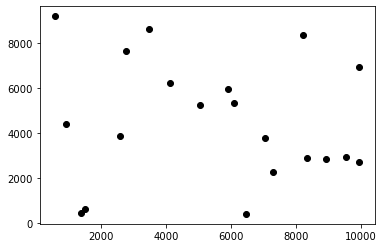

In [3]:
plt.plot(coordlct_x, coordlct_y, 'o', color='black');

### Sets

In [4]:
model = AbstractModel()

# Set of candidate cities
model.N = RangeSet(n)
model.M = RangeSet(n-1)

### Parameters

In [5]:
# c[i,j] - distance from i and j
model.c = Param(model.N, model.N, initialize=cij_model)

# d[j] - demand of customer j
model.d = Param(model.N, initialize=dj_model)

### Decision Variables

In [6]:
# x[i,j] - 1 if city j is visited right after city i, 0 otherwise
model.x = Var(model.N, model.N, within=Binary)

# u[i] - auxiliary variable indicating tour ordering
model.u = Var(model.N, within=NonNegativeReals)

### Objective Function

In [7]:
# Minimize the demand-weighted total cost
def cost_(model):
    return sum(model.c[i,j]*model.x[i,j] for i in model.N for j in model.N)
model.cost = Objective(rule=cost_)

### Constraints

In [8]:
#  Only 1 departs from each city
def departs_(model, j):
    return sum(model.x[i,j] for i in model.N if i!=j ) == 1
model.departs = Constraint(model.M, rule=departs_)

In [9]:
#  Only 1 arrives from each city
def arrives_(model, i):
    return sum(model.x[i,j] for j in model.N if j!=i ) == 1
model.arrives = Constraint(model.M, rule=arrives_)

In [10]:
#  Only nvhc vehicles arrive to the depot  (city with index n)
def arrivesdepot_(model):
    return sum(model.x[i,n] for i in model.N) == nvhc
model.departsdepot = Constraint(rule=arrivesdepot_)

In [11]:
#  Only nvhc vehicles depart to the depot (city with index n)
def departdepot_(model):
    return sum(model.x[n,j] for j in model.N) == nvhc
model.arrivesdepot = Constraint(rule=departdepot_)

In [12]:
def singletour_(model,i,j):
    if i!=j: 
        return model.u[i] - model.u[j] +cvhc*model.x[i,j] <= cvhc-model.d[i]
    else:
        return model.u[n]== 0
    
model.singletour = Constraint(model.M,model.M,rule=singletour_)

### Solve Model

In [13]:
instance = model.create_instance()
opt = pyo.SolverFactory('gurobi')
opt.solve(instance, options={'TimeLimit': 10000},tee=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-11-27
Read LP format model from file C:\Users\NUNORI~1\AppData\Local\Temp\tmpmwk_vhab.pyomo.lp
Reading time = 0.01 seconds
x421: 402 rows, 421 columns, 1808 nonzeros
Set parameter TimeLimit to value 10000
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 402 rows, 421 columns and 1808 nonzeros
Model fingerprint: 0x63c1cddf
Variable types: 21 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [2e+02, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 20 rows and 21 columns
Presolve time: 0.00s
Presolved: 382 rows, 400 columns, 1788 nonzeros
Variable types: 19 continuous, 381 integer (381 binary)

Root relaxation: objective 4.291338e+04, 73 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 1063539 219521     cutoff   57      58996.2525 56424.8879  4.36%  10.1  265s
 1076791 219145 58814.1647   48   26 58996.2525 56446.6531  4.32%  10.2  270s
 1088651 219041 57507.8676   50   17 58996.2525 56465.0735  4.29%  10.2  275s
 1101742 218780 58981.7206   57   22 58996.2525 56486.2772  4.25%  10.2  280s
 1113584 218510 58701.3361   54   24 58996.2525 56504.7624  4.22%  10.2  285s
 1126986 217992 58140.3975   51   24 58996.2525 56526.7333  4.19%  10.2  290s
H1127321 217992                    58996.250198 56526.9168  4.19%  10.2  290s
 1138888 217643 57234.9679   54   18 58996.2502 56546.1579  4.15%  10.2  295s
H1151499 217270                    58996.250190 56566.3457  4.12%  10.2  299s
 1152658 217194 57616.2698   48   18 58996.2502 56568.2782  4.12%  10.2  300s
 1166431 216763 57317.9503   61   20 58996.2502 56589.1104  4.08%  10.2  305s
 1182329 216137     cutoff   48      58996.2502 56613.1453  4.04%  10.3  310s
 1199514 215670 57681.2575   52   23 58996.2502 56639.5651  3.99

{'Problem': [{'Name': 'x421', 'Lower bound': 58996.252451671775, 'Upper bound': 58996.252451671775, 'Number of objectives': 1, 'Number of constraints': 402, 'Number of variables': 421, 'Number of binary variables': 400, 'Number of integer variables': 400, 'Number of continuous variables': 21, 'Number of nonzeros': 1808, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '632.3572196960449', 'Error rc': 0, 'Time': 632.763697385788}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Read output variables

In [14]:
xij_dic = {i:int(value(j)) for (i,j) in instance.x.items()}
xij = pd.DataFrame(xij_dic.values(), index = xij_dic.keys()).unstack()
linkindex = np.where(xij == 1)

In [15]:
ui_dic = {i:int(value(j)) for (i,j) in instance.u.items()}
ui = pd.DataFrame(ui_dic.values(), index = ui_dic.keys()).unstack()
sequence = np.where(ui == 1)
uidf=pd.DataFrame(ui)
uidf=uidf.sort_values(by=[0])

pd.set_option('display.max_rows', uidf.shape[0]+1)


### Plot results

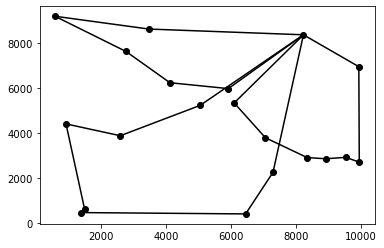

In [20]:
def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-')

for i_index in range(len(linkindex[0])): 
    connectpoints(coordlct_x,coordlct_y,linkindex[0][i_index],linkindex[1][i_index])
    
plt.plot(coordlct_x, coordlct_y, 'o', color='black');
